In [1]:
from IPython.display import HTML

In [2]:
HTML(
    '''
    <script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <a href="javascript:code_toggle()">TOGGLE CODE ON/OFF</a>
    '''
)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Aims-of-notebook" data-toc-modified-id="Aims-of-notebook-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Aims of notebook</a></span></li><li><span><a href="#Basic-steps" data-toc-modified-id="Basic-steps-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Basic steps</a></span></li><li><span><a href="#Sanity-checks-on-motion-energy" data-toc-modified-id="Sanity-checks-on-motion-energy-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Sanity checks on motion energy</a></span></li></ul></div>

# Aims of notebook
- Run ME filters from Kiani's lab on dots stimulus from my dots_db module.
- Explore simple statistics of this ME measure, and run sanity checks

# Basic steps  
1. import dots_db and Kiani's ME modules
2. extract a trial from the db
3. create ME filters
4. apply filters to stimulus 
5. display ME

In [3]:
import sys

# add location of custom modules to path
sys.path.insert(0,'../modules/')
sys.path.insert(0,'../modules/dots_db/dotsDB/')

# add location of data to path -- I couldn't make this work
# sys.path.insert(0,'../../data/')
# sys.path.insert(0,'../modules/dots_db/data/')

In [4]:
# pip modules
import pprint
import numpy as np             
import pandas as pd    
import seaborn as sns
import matplotlib.pyplot as plt
import h5py     

# custom modules
import dotsDB as ddb
import motionenergy as kiani_me
import stimulus as stim
import ME_functions as my_me

In [5]:
# OPTIONS AND CONSTANTS
%matplotlib inline

sns.set(style="darkgrid", context="poster")
TITLE_FS = 22
AXES_FS = 22
plt.rcParams.update({'font.size': AXES_FS}) # font size on axes
plt.subplots_adjust(wspace=0.5) # horizontal space between panels



SKIP_BASIC_STEPS = False

<Figure size 432x288 with 0 Axes>

Step 1 completed by now.

In [6]:
# options are, for now
# '../../data/pilot11.h5'
# '../modules/dots_db/data/test.h5'
# '../modules/dots_db/data/test2.h5'
file_path = '../modules/dots_db/data/test2.h5'

database_info = ddb.inspect_db(file_path)
print('INSPECTING DATABASE:')
object_names = []  # list of object names in database
idx = 0
for l1 in database_info.keys():
    object_names.append(l1)
    print(f"\n Object name {idx}: {l1}")  # print initial group names separately because they are extremely long
    pprint.pprint(database_info[l1], width=60)
    idx += 1

INSPECTING DATABASE:

 Object name 0: intlv3_lftTrue_fr60_fs1.1_sp5_ds90_c0_cs10_dleft_nf15_dm5_sc2.5_ppd55.4612_dts6_fw305
{'attrs': [('coh_mean', 0),
           ('coh_stdev', 10),
           ('density', 90),
           ('diameter', 5),
           ('direction', 'left'),
           ('dot_size_in_pxs', 6),
           ('field_scale', 1.1),
           ('frame_rate', 60),
           ('frame_width_in_pxs', 305),
           ('interleaves', 3),
           ('limit_life_time', True),
           ('num_frames', 15),
           ('pixels_per_degree', 55.4612),
           ('speed', 5),
           ('stencil_radius_in_vis_angle', 2.5)],
 'type': 'group'}

 Object name 1: intlv3_lftTrue_fr60_fs1.1_sp5_ds90_c0_cs10_dleft_nf15_dm5_sc2.5_ppd55.4612_dts6_fw305/px
{'attrs': [], 'shape': (50, 1395375), 'type': 'dataset'}

 Object name 2: intlv3_lftTrue_fr60_fs1.1_sp5_ds90_c0_cs10_dright_nf15_dm5_sc2.5_ppd55.4612_dts6_fw305
{'attrs': [('coh_mean', 0),
           ('coh_stdev', 10),
           ('density', 90),


In [7]:
# from the previous inspection, we see that the datasets we are interested in have odd indices, 
# and their groups even ones

# check there are an even number of objects (for each group, a dataset)
num_db_objects = len(object_names)
assert np.mod(num_db_objects, 2)==0

even_idx = list(range(0, num_db_objects, 2))
odd_idx = list(range(1,num_db_objects, 2))

group_names = [object_names[idx] for idx in even_idx]
dset_names = [object_names[idx] for idx in odd_idx]

In [8]:
if not SKIP_BASIC_STEPS:
    trial_numbers = [1, 10, 30, 50]  # must be at least 1
    dots = [ddb.extract_trial_as_3d_array(file_path, dset_names[0], group_names[0], trial_number) for trial_number in trial_numbers]

In [9]:
# if not SKIP_BASIC_STEPS:
#     plt.rcParams["figure.figsize"] = (18, 12) # (w, h) # figure size 
#     fig, axs = plt.subplots(3, 2)

#     # the following dict conveniently maps frame number to subplot indices,
#     # in order to display two frames next to each other whenever one is the 'successor' from the other
#     # i.e., frames 1 and 4 together, then 2 and 5, etc.
#     frame_to_subplot = {
#         0: (0, 0),
#         3: (0, 1),
#         1: (1, 0),
#         4: (1, 1),
#         2: (2, 0),
#         5: (2, 1)
#     }
#     print(f"PRINTING TRIAL {trial_numbers[-1]} AS AN EXAMPLE")
#     trial = dots[-1]
#     for frame in range(trial.shape[2]):
#         subplot_idx = frame_to_subplot[frame]
#         axs[subplot_idx].imshow(trial[:,:,frame])
#     #     axs[1, 1].set_aspect('equal', 'box')
#         axs[subplot_idx].set_title(f"frame {frame + 1}", fontsize=TITLE_FS)

#     fig.tight_layout()

#     # plt.show()
#     print('Step 2 completed by now')
# else:
#     print('step 2 skipped')

In [10]:
# it is convenient to put the attributes in a dict format
attrs_dicts = [dict(database_info[gname]['attrs']) for gname in group_names]
# pprint.pprint(d)

In [11]:
def all_same(items):
    """returns True if items is empty or all entries are equal"""
    return all(x == items[0] for x in items)

# confirm that all objects in database have same ppd and frame rate attrs
assert all_same([d['pixels_per_degree'] for d in attrs_dicts])
assert all_same([d['frame_rate'] for d in attrs_dicts])

attrs_dict = attrs_dicts[0]  # pick any dict

# filter parameters (there are more, with default values)
ppd, framerate = attrs_dict['pixels_per_degree'], attrs_dict['frame_rate']
filter_shape = 32, 32, 6                 # size parameter of motion_filters()
filter_res = 1 / ppd, 1 / ppd, 1 / framerate

# construct filters
filters = kiani_me.motion_filters(filter_shape, filter_res)

Step 3 completed

In [12]:
if not SKIP_BASIC_STEPS:
#     %%time
    dots_energy = [kiani_me.apply_motion_energy_filters(x, filters) for x in dots]
    print('Step 4 completed')
else:
    print('step 4 skipped')

Step 4 completed


<class 'numpy.ndarray'>
Step 5 completed


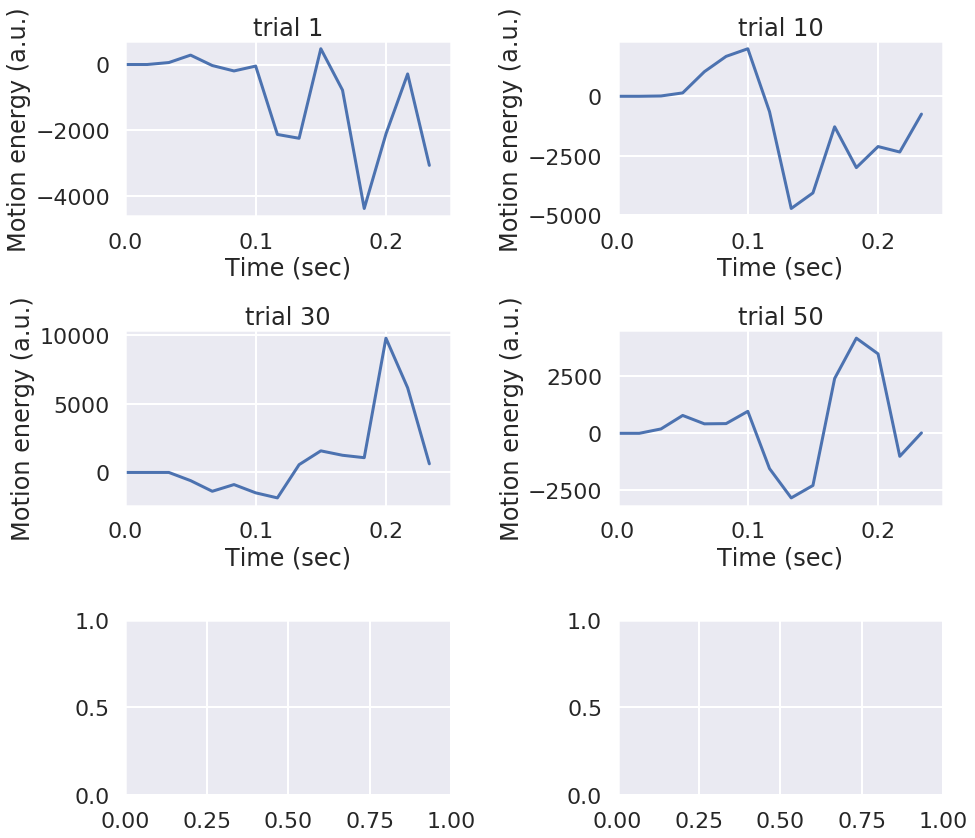

In [13]:
if not SKIP_BASIC_STEPS:
    plt.rcParams["figure.figsize"] = (14, 12) # (w, h) # figure size 
    subplot_shape = (3, 2)
    f, ax = plt.subplots(subplot_shape[0], subplot_shape[1], sharex=False)
    print(type(ax))
    num_frames = attrs_dict['num_frames']
    num_trials = len(trial_numbers)
    for trial_number in range(num_trials):
        # next two lines very inefficient/inelegant
    #     dots_curr_trial = dots_table[dots_table['trialCount'] == (trial + 2)] # TODO: this hard-coding is NOT ROBUST
    #     num_frames = max(dots_curr_trial['frameIdx'])

        t = kiani_me.filter_grid(num_frames, 1 / framerate)
        subplot_idx = np.unravel_index(trial_number, subplot_shape)
        if np.sum(subplot_shape):
            ax[subplot_idx].plot(t, dots_energy[trial_number].sum(axis=(0, 1)))
            ax[subplot_idx].set(xlim=(0, num_frames * (1 / framerate)), ylim=(None, None),
                                xlabel="Time (sec)",
                                ylabel="Motion energy (a.u.)", 
                                title=f"trial {trial_numbers[trial_number]}")
        else:       
            ax.plot(t, dots_energy[trial_number].sum(axis=(0, 1)))
            ax.set(xlim=(0, num_frames * (1 / framerate)), ylim=(None, None),
                   xlabel="Time (sec)",
                   ylabel="Motion energy (a.u.)", 
                   title=f"trial {trial_numbers[trial_number]}")
    f.tight_layout()
    print('Step 5 completed')
else:
    print('step 5 skipped')

# Sanity checks on motion energy

- display ME (averaged across trials), for a whole dataset, add stdev on top of mean.
- repeat the above for the opposite direction of motion (new dataset)
- repeat the above for several coherence levels  

**Steps**   
1. get motion energies in data frame
2. plot results with seaborn

With 100 trials, ME sould take, max, 2min to compute...

In [14]:
# confirm all datasets have same dimension
assert all_same([database_info[dset]['shape'] for dset in dset_names])

# pick any of them
dsetname = dset_names[0]

# trials to extract from each dataset
trial_list = np.arange(1,database_info[dsetname]['shape'][0]+1)

In [15]:
time_next_cell = 21
print(f"WARNING, THE NEXT CELL TAKES SOME TIME TO EXECUTE. LAST TIME IT TOOK {time_next_cell} MINUTES")

WARNING, THE NEXT CELL TAKES SOME TIME TO EXECUTE. LAST TIME IT TOOK 21 MINUTES


In [16]:
%%time
RUN = True
if RUN:
    print(f"applying filters to {len(dset_names)} datasets of {len(trial_list)} trials each")
    df_list = [my_me.compute_motion_energy_for_trials_in_db(file_path, 
                                                            dsetname, 
                                                            gname, 
                                                            trial_list, 
                                                            filters, 
                                                            append_to=None) for (dsetname, 
                                                                                 gname) in zip(dset_names, 
                                                                                               group_names)]
else:
    print(f"As a safeguard, this cell didn't execute. Set the RUN variable to True if you really want to execute it.")

applying filters to 6 datasets of 50 trials each
CPU times: user 8min 37s, sys: 57 s, total: 9min 34s
Wall time: 2min 25s


In [17]:
# concatenate all dataframes together
# %%time # for some reason this line throws an error
print(f"aggregate all data frames into a single one")
agg_df = pd.concat(df_list)

aggregate all data frames into a single one


In [18]:
print("INFO ABOUT AGGREGATE DATA FRAME")
agg_df.info()

INFO ABOUT AGGREGATE DATA FRAME
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 0 to 749
Data columns (total 8 columns):
ME           4500 non-null float64
coherence    4500 non-null int64
density      4500 non-null int64
direction    4500 non-null object
dsetID       4500 non-null object
filtersID    4500 non-null object
time         4500 non-null float64
trial        4500 non-null int64
dtypes: float64(2), int64(3), object(3)
memory usage: 316.4+ KB


In [19]:
agg_df.head()

,ME,coherence,density,direction,dsetID,filtersID,time,trial
0,2.494334e-30,0,90,left,../modules/dots_db/data/test2left0,32_32_11_32_32_11_32_32_11_32_32_11,0.000000,1
1,1.192280e-14,0,90,left,../modules/dots_db/data/test2left0,32_32_11_32_32_11_32_32_11_32_32_11,0.016667,1
2,5.990711e+01,0,90,left,../modules/dots_db/data/test2left0,32_32_11_32_32_11_32_32_11_32_32_11,0.033333,1
3,2.859350e+02,0,90,left,../modules/dots_db/data/test2left0,32_32_11_32_32_11_32_32_11_32_32_11,0.050000,1
4,-3.107728e+01,0,90,left,../modules/dots_db/data/test2left0,32_32_11_32_32_11_32_32_11_32_32_11,0.066667,1


In [20]:
print(f"number of rows in data frame: {len(agg_df)}")

number of rows in data frame: 4500


In [21]:
FILL_DSET_ID_MANUALLY = False
if FILL_DSET_ID_MANUALLY: 
    # since my_me.compute_motion_energy_for_trials_in_db() doesn't yet assign dataset index correctly, I do it manually
    dsetID_col = 4

    rows_per_dset = 600
    num_dsets = len(dset_names)

    assert len(agg_df) == num_dsets * rows_per_dset

    idx_low, idx_up = 0, 0

    for dset_idx in range(num_dsets):
        idx_up += rows_per_dset
        agg_df.iloc[idx_low:idx_up,dsetID_col] = 'dset' + str(dset_idx)
        idx_low = idx_up

In [22]:
SAVE_DATAFRAME = False
file_path = '../../data/test.csv'
if SAVE_DATAFRAME:
    agg_df.to_csv(file_path, index=False)

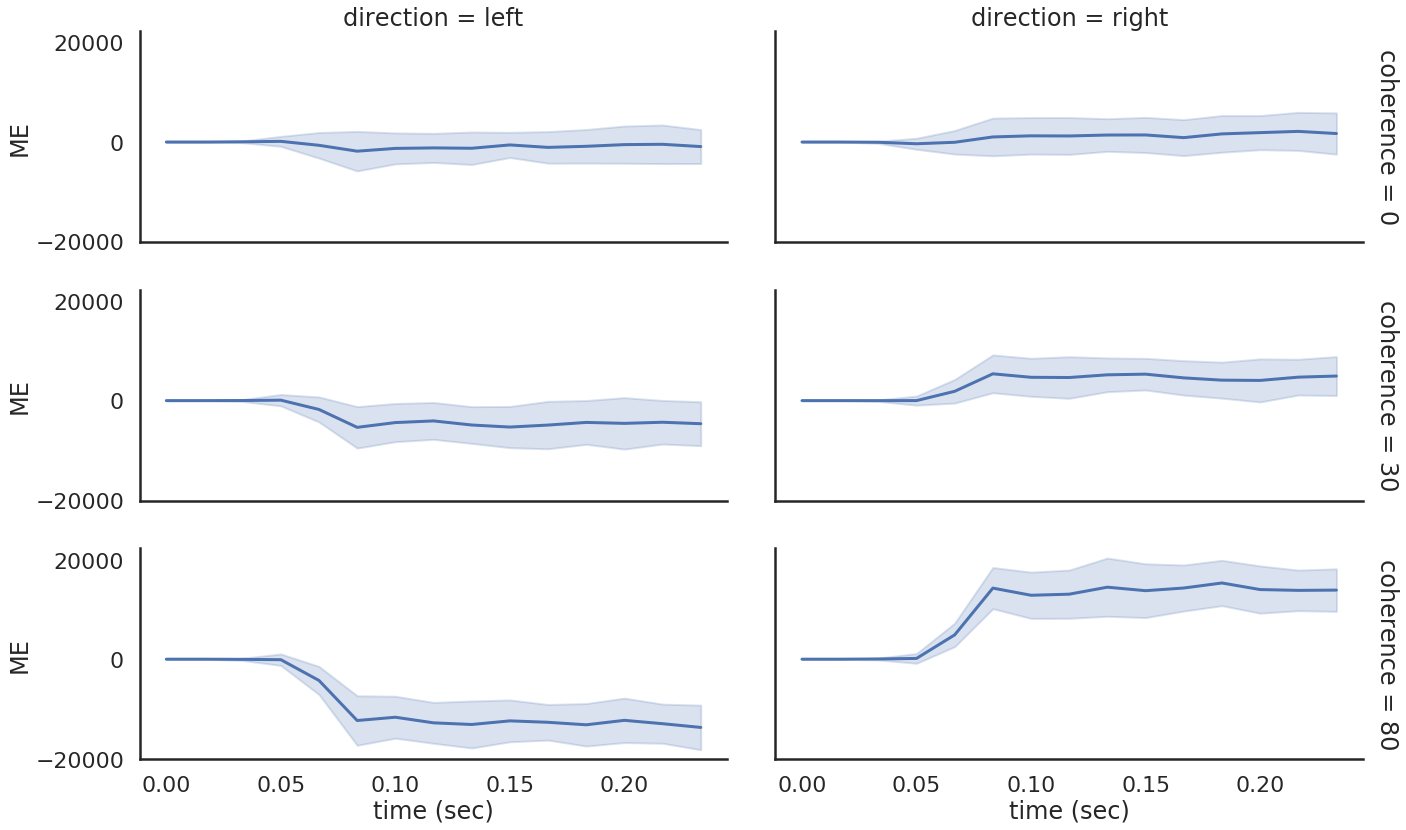

In [23]:
LOAD_DATA_FRAME = False  # if true, should load csv file dumped in previous cell

# somehow in this cell I had to call again these 3 commands
plt.rcParams["figure.figsize"] = (16, 25) # (w, h) # figure size 

with sns.axes_style("white"):
    g = sns.FacetGrid(agg_df, row="coherence", col="direction", margin_titles=True, height=4, aspect=2.5)
g.map(sns.lineplot, "time", "ME", ci="sd");
g.set_axis_labels("time (sec)", "ME");
# g.set(xticks=[10, 30, 50], yticks=[2, 6, 10]);
# g.fig.subplots_adjust(wspace=20, hspace=.2);

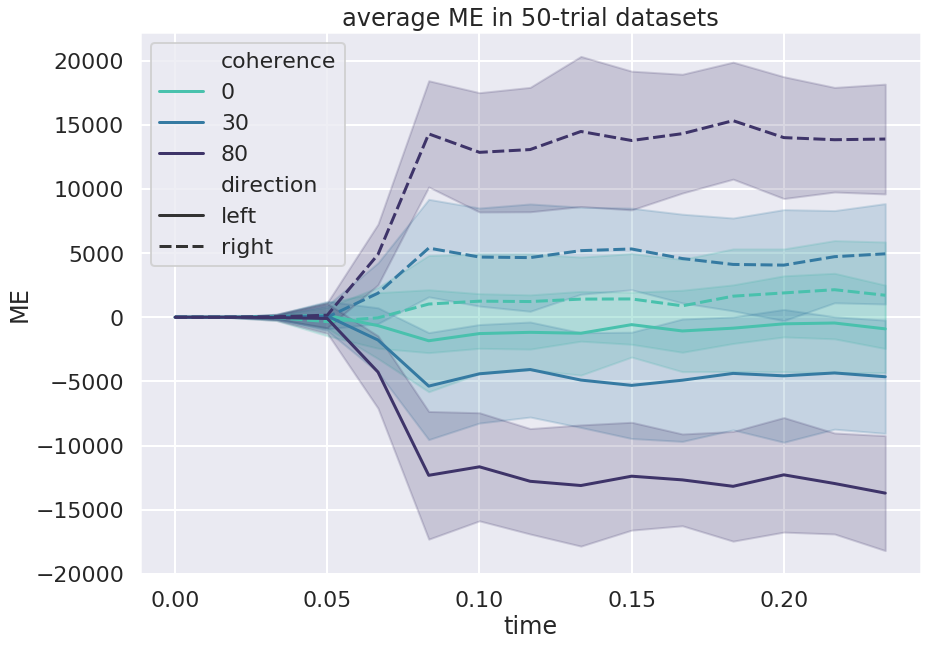

In [25]:
# same data, but overlayed on single plot
# nice ref:
# https://seaborn.pydata.org/generated/seaborn.lineplot.html
plt.rcParams["figure.figsize"] = (14, 10) # (w, h) # figure size 
palette = sns.color_palette("mako_r", 3)
# Plot the responses for different events and regions
ax = sns.lineplot(x="time", y="ME",
                  data=agg_df,
#                   hue="direction", 
                  hue="coherence",
                  style="direction",
#                   size="coherence",
                  palette=palette,
                  ci="sd")
ax.set_title(f'average ME in {len(trial_list)}-trial datasets')
ax.legend(loc='upper left')